In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import warnings
from copy import deepcopy
from functools import lru_cache

import astropy.units as u
import numpy as np
import pandas as pd
from astropy.coordinates import Distance, SkyCoord
from astropy.time import Time
from astropy.wcs import WCS
from astroquery.gaia import Gaia
from scipy import sparse
from tqdm import tqdm

In [5]:
# We'll use this for apertures
def gaussian_2d(x, y, mu_x, mu_y, sigma_x=2, sigma_y=2):
    """
    Compute the value of a 2D Gaussian function.

    Parameters:
    x (float): x-coordinate.
    y (float): y-coordinate.
    mu_x (float): Mean of the Gaussian in the x-direction.
    mu_y (float): Mean of the Gaussian in the y-direction.
    sigma_x (float): Standard deviation of the Gaussian in the x-direction.
    sigma_y (float): Standard deviation of the Gaussian in the y-direction.

    Returns:
    float: Value of the 2D Gaussian function at (x, y).
    """
    part1 = 1 / (2 * np.pi * sigma_x * sigma_y)
    part2 = np.exp(
        -((x - mu_x) ** 2 / (2 * sigma_x**2) + (y - mu_y) ** 2 / (2 * sigma_y**2))
    )
    return part1 * part2

def dgaussian_2d(x, y, mu_x, mu_y, sigma_x=2, sigma_y=2):
    """
    Compute the value of a 2D Gaussian function. (This returns the amplitude you need to multiply by a Gaussian to get the actual gradient.)

    Parameters:
    x (float): x-coordinate.
    y (float): y-coordinate.
    mu_x (float): Mean of the Gaussian in the x-direction.
    mu_y (float): Mean of the Gaussian in the y-direction.
    sigma_x (float): Standard deviation of the Gaussian in the x-direction.
    sigma_y (float): Standard deviation of the Gaussian in the y-direction.

    """
    
    dG_x = -(x - mu_x)/sigma_x**2
    dG_y = -(y - mu_y)/sigma_y**2
    return dG_x, dG_y

class SparseWarp3D(sparse.coo_matrix):
    """Special class for working with stacks of sparse 3D images"""

    def __init__(self, data, row, col, imshape):
        if not np.all([row.ndim == 3, col.ndim == 3, data.ndim == 3]):
            raise ValueError("Pass a 3D array (nrow, ncol, nvecs)")
        self.nvecs = data.shape[-1]
        if not np.all(
            [
                row.shape[-1] == self.nvecs,
                col.shape[-1] == self.nvecs,
            ]
        ):
            raise ValueError("Must have the same 3rd dimension (nvecs).")
        self.subrow = row.astype(int)
        self.subcol = col.astype(int)
        self.subdepth = (
            np.arange(row.shape[-1], dtype=int)[None, None, :]
            * np.ones(row.shape, dtype=int)[:, :, None]
        )
        self.subdata = data
        self._kz = self.subdata != 0

        self.imshape = imshape
        self.subshape = row.shape
        self.cooshape = (np.prod([*self.imshape[:2]]), self.nvecs)
        self.coord = (0, 0)
        super().__init__(self.cooshape)
        index0 = (np.vstack(self.subrow)) * self.imshape[1] + (np.vstack(self.subcol))
        index1 = np.vstack(self.subdepth).ravel()
        self._index_no_offset = np.vstack([index0.ravel(), index1.ravel()])
        self._submask_no_offset = np.vstack(self._get_submask(offset=(0, 0))).ravel()
        self._subrow_v = deepcopy(np.vstack(self.subrow).ravel())
        self._subcol_v = deepcopy(np.vstack(self.subcol).ravel())
        self._subdata_v = deepcopy(np.vstack(deepcopy(self.subdata)).ravel())
        self._index1 = np.vstack(self.subdepth).ravel()

        self._set_data()

    def __add__(self, other):
        if isinstance(other, SparseWarp3D):
            data = deepcopy(self.subdata + other.subdata)
            if (
                (self.subcol != other.subcol)
                | (self.subrow != other.subrow)
                | (self.imshape != other.imshape)
                | (self.subshape != other.subshape)
            ):
                raise ValueError("Must have same base indicies.")
            return SparseWarp3D(
                data=data, row=self.subrow, col=self.subcol, imshape=self.imshape
            )
        else:
            return super(sparse.coo_matrix, self).__add__(other)

    def tocoo(self):
        return sparse.coo_matrix((self.data, (self.row, self.col)), shape=self.cooshape)

    def index(self, offset=(0, 0)):
        """Get the 2D positions of the data"""
        if offset == (0, 0):
            return self._index_no_offset
        index0 = (self._subrow_v + offset[0]) * self.imshape[1] + (
            self._subcol_v + offset[1]
        )
        return index0, self._index1

    def _get_submask(self, offset=(0, 0)):
        # find where the data is within the array bounds
        kr = ((self.subrow + offset[0]) < self.imshape[0]) & (
            (self.subrow + offset[0]) >= 0
        )
        kc = ((self.subcol + offset[1]) < self.imshape[1]) & (
            (self.subcol + offset[1]) >= 0
        )
        return kr & kc & self._kz

    def _set_data(self, offset=(0, 0)):
        if offset == (0, 0):
            index0, index1 = self.index((0, 0))
            self.row, self.col = (
                index0[self._submask_no_offset],
                index1[self._submask_no_offset],
            )
            self.data = self._subdata_v[self._submask_no_offset]
        else:
            # find where the data is within the array bounds
            k = self._get_submask(offset=offset)
            k = np.vstack(k).ravel()
            new_row, new_col = self.index(offset=offset)
            self.row, self.col = new_row[k], new_col[k]
            self.data = self._subdata_v[k]
        self.coord = offset

    def __repr__(self):
        return (
            f"<{(*self.imshape, self.nvecs)} SparseWarp3D array of type {self.dtype}>"
        )

    def dot(self, other):
        if other.ndim == 1:
            other = other[:, None]
        nt = other.shape[1]
        return super().dot(other).reshape((*self.imshape, nt)).transpose([2, 0, 1])

    def reset(self):
        """Reset any translation back to the original data"""
        self._set_data(offset=(0, 0))
        self.coord = (0, 0)
        return

    def clear(self):
        """Clear data in the array"""
        self.data = np.asarray([])
        self.row = np.asarray([])
        self.col = np.asarray([])
        self.coord = (0, 0)
        return

    def translate(self, position):
        """Translate the data in the array by `position` in (row, column)"""
        self.reset()
        # If translating to (0, 0), do nothing
        if position == (0, 0):
            return
        self.clear()
        self._set_data(position)
        return

In [6]:
@lru_cache()
def _query_gaia(query_str):
    job = Gaia.launch_job_async(query_str, verbose=False)
    tbl = job.get_results()
    return deepcopy(tbl)

In [7]:
def get_sky_catalog(
    ra=210.8023,
    dec=54.349,
    radius=0.155,
    grpmagnitude_range=(-3, 20),
    epoch=Time.now(),
    limit=None,
    gaia_keys=[
        "source_id",
        "ra",
        "dec",
        "parallax",
        "pmra",
        "pmdec",
        "radial_velocity",
        "ruwe",
        "phot_rp_mean_flux",
        "teff_gspphot",
        "logg_gspphot",
    ],
):
    """Gets a catalog of coordinates on the sky based on an input ra, dec and radius"""

    query_str = f"""
    SELECT {f'TOP {limit} ' if limit is not None else ''}* FROM (
        SELECT gaia.{', gaia.'.join(gaia_keys)}, dr2.teff_val AS dr2_teff_val,
        dr2.rv_template_logg AS dr2_logg, tmass.j_m, tmass.j_msigcom, tmass.ph_qual, DISTANCE(
        POINT({u.Quantity(ra, u.deg).value}, {u.Quantity(dec, u.deg).value}),
        POINT(gaia.ra, gaia.dec)) AS ang_sep,
        EPOCH_PROP_POS(gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec,
        gaia.radial_velocity, gaia.ref_epoch, 2000) AS propagated_position_vector
        FROM gaiadr3.gaia_source AS gaia
        JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
        JOIN gaiadr3.dr2_neighbourhood AS xmatch2 ON gaia.source_id = xmatch2.dr3_source_id
        JOIN gaiadr2.gaia_source AS dr2 ON xmatch2.dr2_source_id = dr2.source_id
        JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
        JOIN gaiadr1.tmass_original_valid AS tmass ON
        xjoin.original_psc_source_id = tmass.designation
        WHERE 1 = CONTAINS(
        POINT({u.Quantity(ra, u.deg).value}, {u.Quantity(dec, u.deg).value}),
        CIRCLE(gaia.ra, gaia.dec, {(u.Quantity(radius, u.deg) + 50*u.arcsecond).value}))
        AND gaia.parallax IS NOT NULL
        AND gaia.phot_rp_mean_mag > {grpmagnitude_range[0]}
        AND gaia.phot_rp_mean_mag < {grpmagnitude_range[1]}) AS subquery
    WHERE 1 = CONTAINS(
    POINT({u.Quantity(ra, u.deg).value}, {u.Quantity(dec, u.deg).value}),
    CIRCLE(COORD1(subquery.propagated_position_vector), COORD2(subquery.propagated_position_vector), {u.Quantity(radius, u.deg).value}))
    ORDER BY ang_sep ASC
    """
    tbl = _query_gaia(query_str)
    if len(tbl) == 0:
        raise ValueError("Could not find matches.")

    tbl = tbl.to_pandas()
    k = (~np.isfinite(tbl["parallax"])) | (tbl["parallax"] < 0)
    tbl.loc[k, "parallax"] = 0
    k = ~np.isfinite(tbl["logg_gspphot"])
    tbl.loc[k, "logg_gspphot"] = tbl["dr2_logg"][k]
    k = ~np.isfinite(tbl["teff_gspphot"])
    tbl.loc[k, "teff_gspphot"] = tbl["dr2_teff_val"][k]
    k = ~np.isfinite(tbl["ruwe"])
    tbl.loc[k, "ruwe"] = 99
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c = SkyCoord(
            ra=tbl["ra"] * u.deg,
            dec=tbl["dec"] * u.deg,
            pm_ra_cosdec=np.nan_to_num(tbl["pmra"]) * u.mas / u.year,
            pm_dec=np.nan_to_num(tbl["pmdec"]) * u.mas / u.year,
            obstime=Time.strptime("2016", "%Y"),
            distance=Distance(
                parallax=np.asarray(tbl["parallax"]) * u.mas, allow_negative=True
            ),
            radial_velocity=np.nan_to_num(tbl["radial_velocity"]) * u.km / u.s,
        ).apply_space_motion(epoch)
        tbl["RA_EPOCH"] = c.ra.deg
        tbl["DEC_EPOCH"] = c.dec.deg
    return tbl

In [8]:
from astropy.io import fits

In [7]:
hdulist = fits.open(
    # "/Users/chedges/Downloads/ffis/tess2022363171841-s0060-1-3-0249-s_ffic.fits"
    "./data/tess2022363171841-s0060-1-3-0249-s_ffic.fits"
)
wcs = WCS(hdulist[1].header)

# use a cutout of a tess FFI
R, C = np.mgrid[1500:1700, 1501:1700]
image_shape = R.shape
R0, C0 = R[:, 0].mean(), C[0].mean()
wR, wC = R - R0, C - C0
data = hdulist[1].data[1500:1700, 1501:1700]
err = hdulist[2].data[1500:1700, 1501:1700]


c = wcs.pixel_to_world(R0, C0)
ra0, dec0 = c.ra.deg, c.dec.deg
l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
cs = wcs.pixel_to_world(R[l[0], l[1]], C[l[0], l[1]])
radius = np.max(c.separation(cs).deg)
df = get_sky_catalog(
    ra0,
    dec0,
    radius=radius,
    grpmagnitude_range=(-3, 16),
    epoch=Time(hdulist[0].header["DATE-OBS"]),
)
df[["X0", "Y0"]] = np.round(np.asarray(
    wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
).T, 2)

k = (
    (df.X0 > R[0, 0] - 3)
    & (df.X0 < R[-1, 0] + 3)
    & (df.Y0 > C[0, 0] - 3)
    & (df.Y0 < C[0, -1] + 3)
)
df = df[k]


k = data.ravel() < np.percentile(data, 20)
polyorder = 2
poly = np.vstack(
    [
        wR.ravel() ** idx * wC.ravel() ** jdx
        for idx in range(polyorder + 1)
        for jdx in range(polyorder + 1)
    ]
).T
bkg_model = poly.dot(
    np.linalg.solve(poly[k].T.dot(poly[k]), poly[k].T.dot(data.ravel()[k]))
).reshape(data.shape)
data -= bkg_model

Set MJD-END to 59942.729154 from DATE-END'. [astropy.wcs.wcs]


INFO: Query finished. [astroquery.utils.tap.core]


In [8]:
df = df.sort_values('phot_rp_mean_flux')
df = df.drop_duplicates(['X0', 'Y0'], keep='first')
df = df.reset_index(drop=True)

In [9]:
len(df)

3143

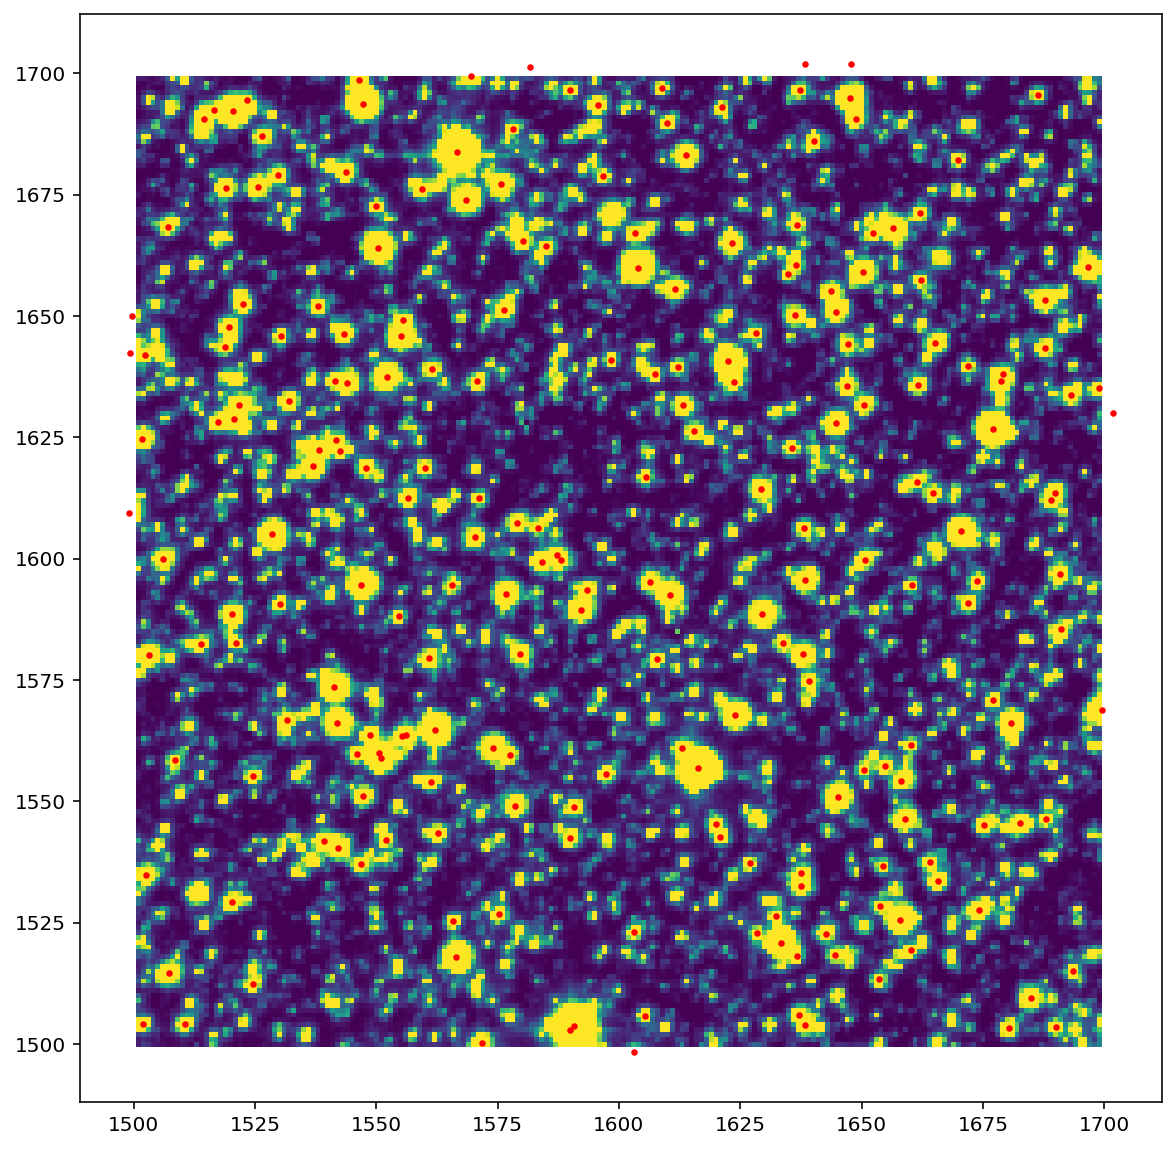

In [10]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, data, vmin=0, vmax=100)
k = df.phot_rp_mean_flux > 1e5
plt.scatter(df["X0"][k], df["Y0"][k], s=5, c="r")

plt.gca().set_aspect("equal")

In [12]:
def get_gaussian_psfs(source_flux, std=1.5):
    nstddevs = 5
    gR, gC = np.mgrid[
        np.floor(-nstddevs * std) : np.ceil(nstddevs * std + 1),
        np.floor(-nstddevs * std) : np.ceil(nstddevs * std) + 1,
    ]
    
    gauss = gaussian_2d(
        gC[:, :, None],
        gR[:, :, None],
        np.asarray(df['X0'] % 1),
        np.asarray(df['Y0'] % 1),
        np.atleast_1d(std),
        np.atleast_1d(std),
    )
    
    # dG_x, dG_y of the gaussian is the thing you have to multiply by the gaussian to get the gradient
    dG_x, dG_y = dgaussian_2d(
        gC[:, :, None],
        gR[:, :, None],
        np.asarray(df['X0'] % 1),
        np.asarray(df['Y0'] % 1),
        np.atleast_1d(std),
        np.atleast_1d(std),
    )
        
    s = SparseWarp3D(
            gauss * source_flux,
            gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
            gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
            image_shape,
        )
        
    ds_x = SparseWarp3D(
            dG_x * gauss * source_flux,
            gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
            gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)
    
    ds_y = SparseWarp3D(
            dG_y *  gauss * source_flux,
            gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
            gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)
    components = [s, ds_x, ds_y]
    return sparse.hstack(components, 'csr')

When building a design matrix for fitting the source flux, the shape of the design matrix is (n_sources, n_components of the image model (in this case3: image, gradient in x and gradient in y)). Then you dot it with a vector that is lenghth=n_sources


When building a design matrix for fitting the PSF shape, the vector will have a length of number of pixels in the entire image (but masked down to the number of pixels that are being fit (so all the pixels in the image that have been identified as having only one source in them)). The design matrix will have width of that and lenght of number of components in the functional form of the PSF being fit.

Quick note about dotting by the mean fluxes before doing flux fitting: this keeps all the flux weights close to 1, which makes it easier to apply priors later.

We want to fit this, which is the sum of the 2D gaussians representing sources in the image

$$ f(x) = \sum_{i=1}^{n} a_i e^{-\frac{(x - b_i)^2}{2c_i^2}} $$

To make this a linear model is tricky, we're going to choose places in the dataset where we are confident there is only one source contributing. We then divide each pixel by the amplitude of that source, to get this:

$$ e^{-\frac{(x - b_i)^2}{2c_i^2}} $$

When we take natural log we get many samples of this function

$$ -\frac{(x - b_i)^2}{2c_i^2} $$

This is something we can fit!

$$ \frac{1}{2c_i^2} (x - b_i)^2 $$

We can do it in polar coordinates...

$$ f(r, \theta) = a e^{-\frac{r^2}{2\sigma^2}} $$

$$ f(r, \theta) = a e^{-\frac{r^2}{2\sigma^2}} + a e^{-\frac{r^3}{2\sigma^2}} + a^2 e^{-\frac{r^2}{2\sigma^2}}$$

$$ f(x) = a_i e^{-\frac{(x - b_i)^2}{2c_i^2}} $$
$$ \log(f(x)) = \log\left(a_i e^{-\frac{(x - b_i)^2}{2c_i^2}}\right) = \log a_i + -\frac{(x - b_i)^2}{2c_i^2}$$

$$ \log(f(x)) = \log\left(\sum_{i=1}^{n} a_i e^{-\frac{(x - b_i)^2}{2c_i^2}}\right) != \sum_{i=1}^{n} .... $$$$ 

Gotcha, 

- Non linearity
- How do you guess which pixels have only one source (discussed in the paper)


0. Review the notebooks, and PSF paper, look at the PSFmachine code, write down any questions for me or Jorge, who is the other expert in this. Note, in that we didn't have SparseWarp3D, which turns out to greatly speed up some stuff.
1. Write a script to help get at the initial guess of the PSF shape, we can be more sophisticated here than in the PSFmachine paper/implementation, have a think about this one.
    a. You're going make assumptions like you can ignore sources below a certain magnitude threshold, and that most pixels don't have multiple sources in. You'll also end up iterating.
2. Write some infrastructure (and heavily copy from notebooks) to be able to make some matrices for fitting PSF shape (in log space) and PSF flux (in linear space).
    a. You're going to have to think a little carefully about your API here. Have a go, and then we'll work together.
    b. You can absolutely use the get_gaussian_psf stuff from this notebook
3. Try fitting some PSF shapes, and use the Gaia flux to see if your resultant images look reasonable.
4. Once they do, try making infrastructure to iterate and iteratively fit shape and flux
5. Once this works well, we can start adding the gradients to the PSF model, so that we can additionally fit for small shifts in position.

$$ f(x) = \sum_{i=1}^{n} a_i e^{-\frac{(x - b_i)^2}{2c_i^2}} $$


$$ f(r, \theta) = \sum_{i=1}^{n} a_i w {\frac{1}{r^2}} ..... $$

fit to find w
fit to find $a_i$
 
$$ P_0 = \sum_{i=1}^{n} a_i w {\frac{1}{r^2}} ..... $$

Use that to find pixels with one source in (to some fideltiy)

In [ ]:
y = data.ravel()
yerr = err.ravel()

# we are only going to consider points that have contributions from ONE SOURCE ONLY
# we are then going to normalize each point to divide out our GUESS of the amplitude of the PSF at that point.


normed_y = y / "source_flux"
normed_yerr = yerr/ "source_flux"


y = np.log(normed_y)
yerr = (np.abs((1/y)) * normed_yerr)

In [15]:
get_gaussian_psfs(source_flux=np.asarray(df.phot_rp_mean_flux))

<39800x3145 sparse matrix of type '<class 'numpy.float64'>'
	with 930166 stored elements in Compressed Sparse Row format>

In [1]:
def get_polar_psfs(source_mask=None):
    if source_mask is None:
        source_mask = np.ones(len(df), bool)
    npixel_radii = 8
    gR, gC = np.mgrid[-npixel_radii:npixel_radii+1, -npixel_radii:npixel_radii+1].astype(float)
    dR = gR[None, :, :] - np.asarray(df['X0'][source_mask] % 1)[:, None, None]
    dC = gC[None, :, :] - np.asarray(df['Y0'][source_mask] % 1)[:, None, None]
    
    rad, phi = np.hypot(dR, dC), np.arctan2(dC, dR)
    s0 = SparseWarp3D(
            rad.transpose([1, 2, 0])**(-2),
            gR[:, :, None] + np.asarray(np.floor(df['X0'][source_mask] - R[0, 0])).astype(int),
            gC[:, :, None] + np.asarray(np.floor(df['Y0'][source_mask] - C[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)
    
    # s1 = SparseWarp3D(
    #         (rad * np.asarray(df.phot_rp_mean_flux)[:, None, None][source_mask]).transpose([1, 2, 0])**(-2),
    #         gR[:, :, None] + np.asarray(np.floor(df['X0'][source_mask] - R[0, 0])).astype(int),
    #         gC[:, :, None] + np.asarray(np.floor(df['Y0'][source_mask] - C[0, 0])).astype(int),
    #         image_shape,
    #     ).sum(axis=1)
    
    # s2 = SparseWarp3D(
    #         (rad * np.asarray(df.phot_rp_mean_flux)[:, None, None][source_mask]**2).transpose([1, 2, 0])**(-2),
    #         gR[:, :, None] + np.asarray(np.floor(df['X0'][source_mask] - R[0, 0])).astype(int),
    #         gC[:, :, None] + np.asarray(np.floor(df['Y0'][source_mask] - C[0, 0])).astype(int),
    #         image_shape,
    #     ).sum(axis=1)
    return sparse.csr_matrix(np.asarray([s0, np.ones_like(s0)])[:, :, 0].T)

In [2]:
pps = get_polar_psfs()
pps

NameError: name 'np' is not defined

In [244]:
y = data.ravel()
yerr = err.ravel()

# Finite pixels
k = np.isfinite(y)

finite_pixel_mask
single_source_mask
positive_pixel_mask

pixel_mask = finite_pixel_mask & single_source_mask & positive_pixel_mask


source_flux = np.asarray(df.phot_rp_mean_flux)

# Guess standard deviation of 1.5 pixel
# should be S, since it's a matrix
s = get_gaussian_psfs(source_flux, 1.)

flux_mask = np.zeros(s.shape[1], bool)
flux_mask[:len(df)] = True

# this step is fitting fluxes
# w ends up being the mean flux estimate for each source
sigma_w_inv = s[k].T.dot(s[k]/yerr[k, None]**2)
w = np.linalg.solve(sigma_w_inv, s[k].T.dot(y[k]/yerr[k]**2))  # divide by yerr to weight by error


# Pixel contributed to by a single source
j = np.asarray((s[:, flux_mask].multiply(w[flux_mask]) > 1e-2).sum(axis=1))[:, 0] == 1

normed_y = y/s.dot(np.ones(s.shape[1]))
normed_yerr = yerr/s.dot(np.ones(s.shape[1]))
l = normed_y > 0

y = np.log(normed_y[k&j&l])
yerr = (np.abs((1/y)) * normed_yerr[k&j&l])

#g0 = get_gaussian_psfs(np.ones(len(source_flux)), 1)

# sigma_w_inv = s[k].T.dot(s[k]/yerr[k, None]**2)
# w = np.linalg.solve(sigma_w_inv, s[k].T.dot(y[k]/yerr[k]**2))

In [1]:
s.shape

NameError: name 's' is not defined

In [245]:
source_mask = np.asarray((s.multiply(j[:, None]).sum(axis=0) != 0))[0][flux_mask] != 0

In [246]:
p0 = get_polar_psfs(source_mask=source_mask)
sigma_w_inv = p0[k&j&l].T.dot(p0[k&j&l]/yerr[:, None]**2)
w = np.linalg.solve(sigma_w_inv, p0[k&j&l].T.dot(y/yerr**2))

In [258]:
18/11

1.6363636363636365

In [260]:
24/17

1.411764705882353

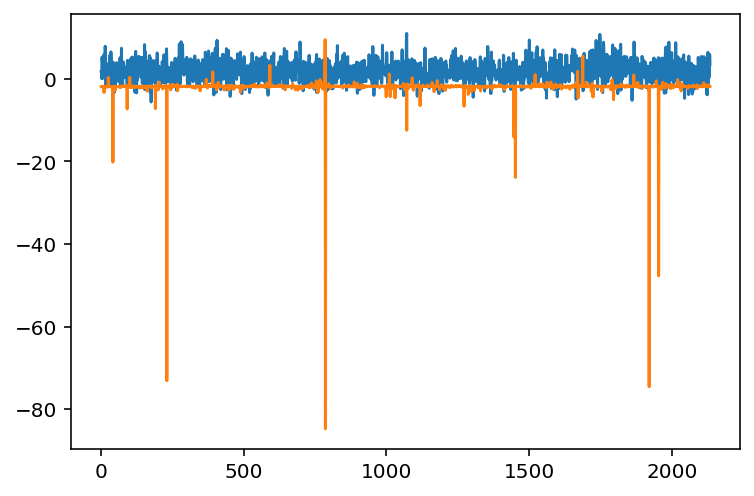

In [253]:
plt.plot(y)
plt.plot(p0[k&j&l].dot(w))

In [199]:
sigma_w_inv = s[k].T.dot(s[k]/yerr[k, None]**2)
w = np.linalg.solve(sigma_w_inv, s[k].T.dot(y[k]/yerr[k]**2))


array([1.80194128, 1.33655196, 0.0677757 , ..., 0.50818551, 5.9045397 ,
       3.42269852])

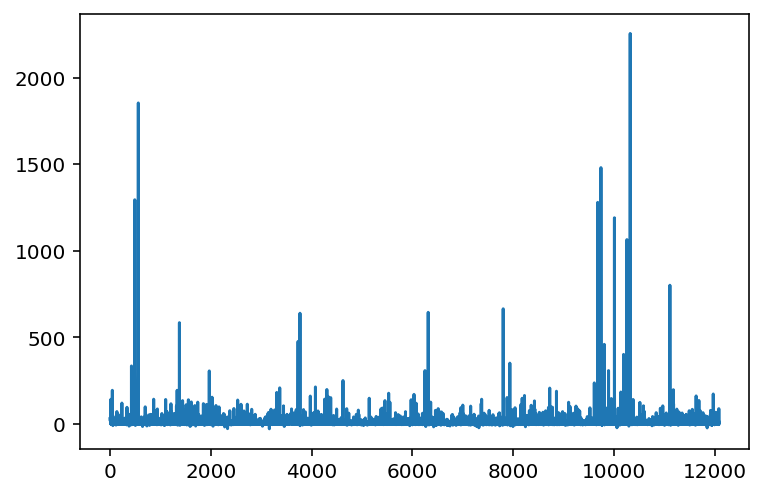

In [145]:
plt.plot(y[k]/s.dot(np.ones(s.shape[1]))[k])

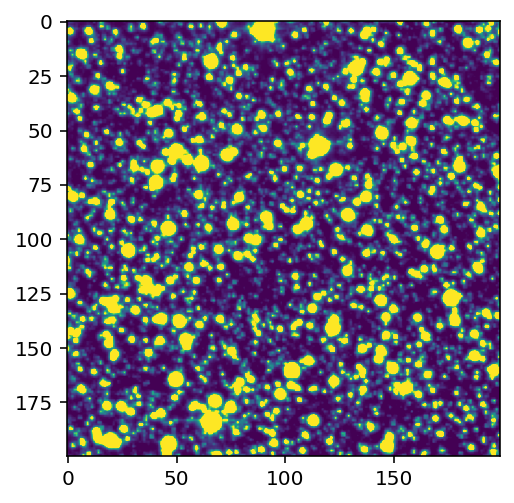

In [79]:
plt.imshow(data, vmin=0, vmax=100)

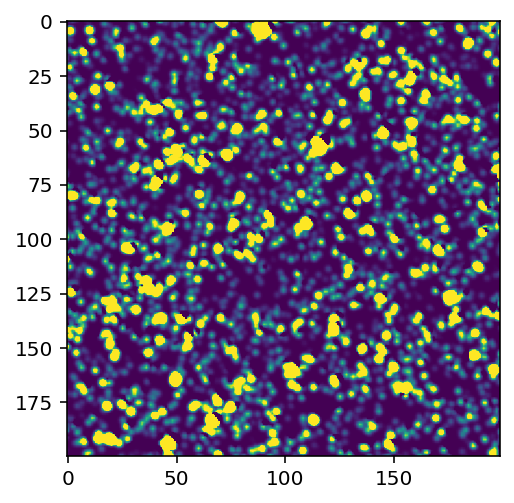

In [84]:
plt.imshow(s.dot(w).reshape(image_shape), vmin=0, vmax=100)

In [11]:
# def get_psfs():
#     npixel_radii = 8
#     gR, gC = np.mgrid[-npixel_radii:npixel_radii+1, -npixel_radii:npixel_radii+1].astype(float)
#     dR = gR[None, :, :] - np.asarray(df['X0'] % 1)[:, None, None]
#     dC = gC[None, :, :] - np.asarray(df['Y0'] % 1)[:, None, None]
    
#     rad, phi = np.hypot(dR, dC), np.arctan2(dC, dR)
# #    rad *= np.asarray(df.phot_rp_mean_flux)[:, None, None]
#     s0 = SparseWarp3D(
#             rad.transpose([1, 2, 0])**(-2),
#             gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
#             gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
#             image_shape,
#         ).sum(axis=1)
    
#     s1 = SparseWarp3D(
#             (rad * np.asarray(df.phot_rp_mean_flux)[:, None, None]).transpose([1, 2, 0])**(-2),
#             gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
#             gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
#             image_shape,
#         ).sum(axis=1)
    
#     s2 = SparseWarp3D(
#             (rad * np.asarray(df.phot_rp_mean_flux)[:, None, None]**2).transpose([1, 2, 0])**(-2),
#             gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
#             gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
#             image_shape,
#         ).sum(axis=1)
#     return sparse.csr_matrix(np.asarray([s0, s1, s2, np.ones_like(s0)])[:, :, 0].T)
#     return sparse.hstack([s0, s1, s2], 'csr')

In [11]:
def get_gaussian_psfs(source_flux, std=1.5):
    nstddevs = 5
    gR, gC = np.mgrid[
        np.floor(-nstddevs * std) : np.ceil(nstddevs * std + 1),
        np.floor(-nstddevs * std) : np.ceil(nstddevs * std) + 1,
    ]
    data = gaussian_2d(
        gC[:, :, None],
        gR[:, :, None],
        np.asarray(df['X0'] % 1),
        np.asarray(df['Y0'] % 1),
        np.atleast_1d(std),
        np.atleast_1d(std),
    )
    s0 = SparseWarp3D(
        data**0 * source_flux,
        gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
        gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
        image_shape,
    ).sum(axis=1)

    s1 = SparseWarp3D(
            data * source_flux,
            gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
            gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)

    s2 = SparseWarp3D(
        data**2 * source_flux,
        gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
        gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
        image_shape,
    ).sum(axis=1)

    dG_x, dG_y = dgaussian_2d(
        gC[:, :, None],
        gR[:, :, None],
        np.asarray(df['X0'] % 1),
        np.asarray(df['Y0'] % 1),
        np.atleast_1d(std),
        np.atleast_1d(std),
    )
        
    ds_x = SparseWarp3D(
            dG_x * data * source_flux,
            gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
            gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)
    ds_y = SparseWarp3D(
            dG_y *  data * source_flux,
            gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
            gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)

    components = [s1, ds_x, ds_y]
    
    
    return np.asarray(components)[:, :, 0].T
    #return sparse.hstack(components, 'csr')

In [522]:
source_flux = np.asarray(df.phot_rp_mean_flux)
source_flux /= np.median(source_flux)
s = get_gaussian_psfs(source_flux, 1)

y = data.ravel()
yerr = err.ravel()
k = np.isfinite(y)
s = get_gaussian_psfs(source_flux, std=0.6)
sigma_w_inv = s[k].T.dot(s[k]/yerr[k, None]**2)
w = np.linalg.solve(sigma_w_inv, s[k].T.dot(y[k]/yerr[k]**2))

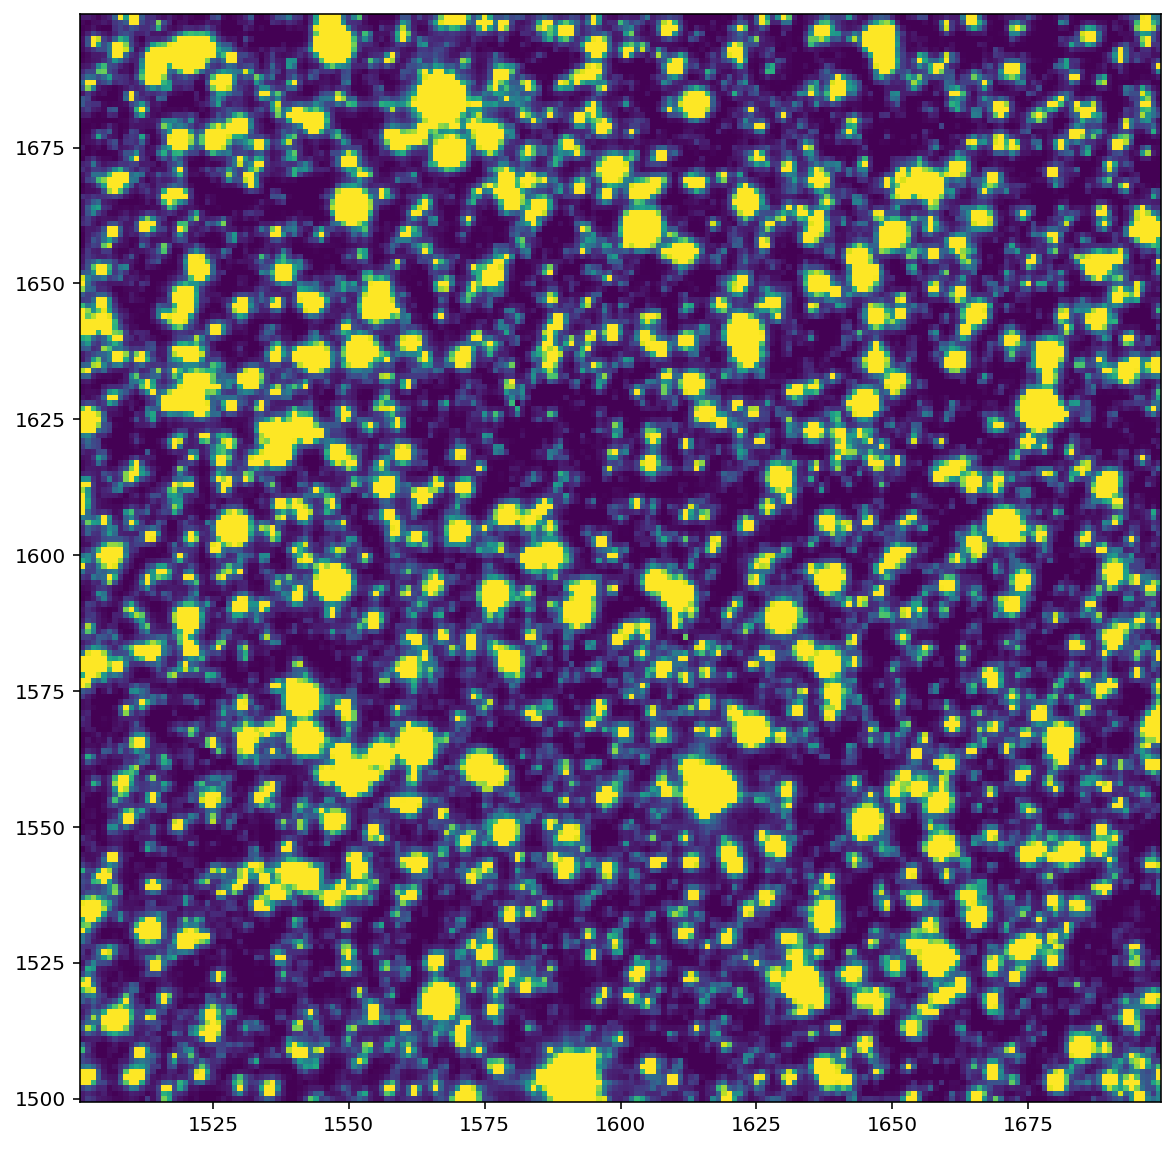

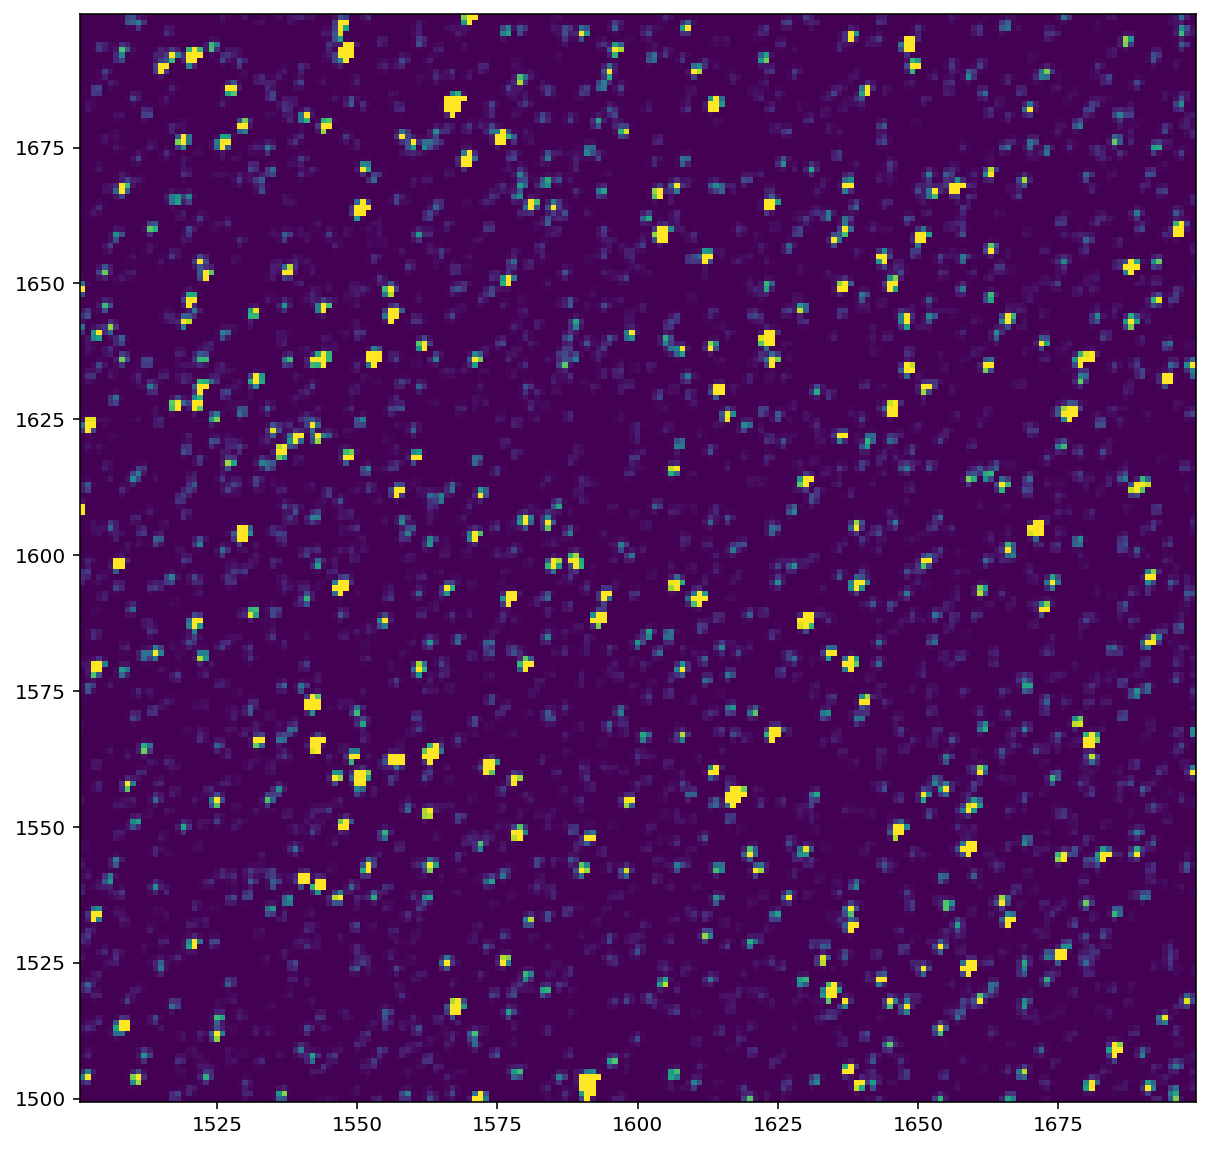

In [523]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, data, vmin=0, vmax=100)
plt.gca().set_aspect("equal")

plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, s.dot(w).reshape(image_shape), vmin=0, vmax=100)

In [475]:
# y = np.log(data.ravel())
# yerr = (np.abs((1/y)) * err.ravel())
y = data.ravel()
yerr = err.ravel()

# prior_sigma = np.ones(s.shape[1]) * 1e2
# prior_mu = np.ones(s.shape[1])

k = np.isfinite(y)

# sigmas = np.linspace(1, 1.5, 30)
# chis = np.zeros_like(sigmas)
# for idx, sigma in enumerate(tqdm(sigmas)):
#     s = get_gaussian_psfs(sigma)
#     sigma_w_inv = s[k].T.dot(s[k].multiply(1/yerr[k, None]**2)).toarray() 
#     source_flux = np.linalg.solve(sigma_w_inv, s[k].T.dot(y[k]/yerr[k]**2))
#     chis[idx] = np.sum((y[k] - s.dot(source_flux)[k])**2/yerr[k]**2)

s = get_gaussian_psfs(1)
sigma_w_inv = s[k].T.dot(s[k].multiply(1/yerr[k, None]**2)).toarray() 
source_flux = np.linalg.solve(sigma_w_inv, s[k].T.dot(y[k]/yerr[k]**2))
chis[idx] = np.sum((y[k] - s.dot(source_flux)[k])**2/yerr[k]**2)

AttributeError: 'numpy.ndarray' object has no attribute 'multiply'

In [ ]:
# plt.plot(sigmas, chis)

In [395]:
#np.median(source_flux[829*2:829*3])

In [389]:
# plt.plot(source_flux[829:829*2])
# plt.ylim(-1, 1)

In [390]:
# plt.plot(source_flux)

ValueError: shapes (39800,5) and (3143,) not aligned: 5 (dim 1) != 3143 (dim 0)

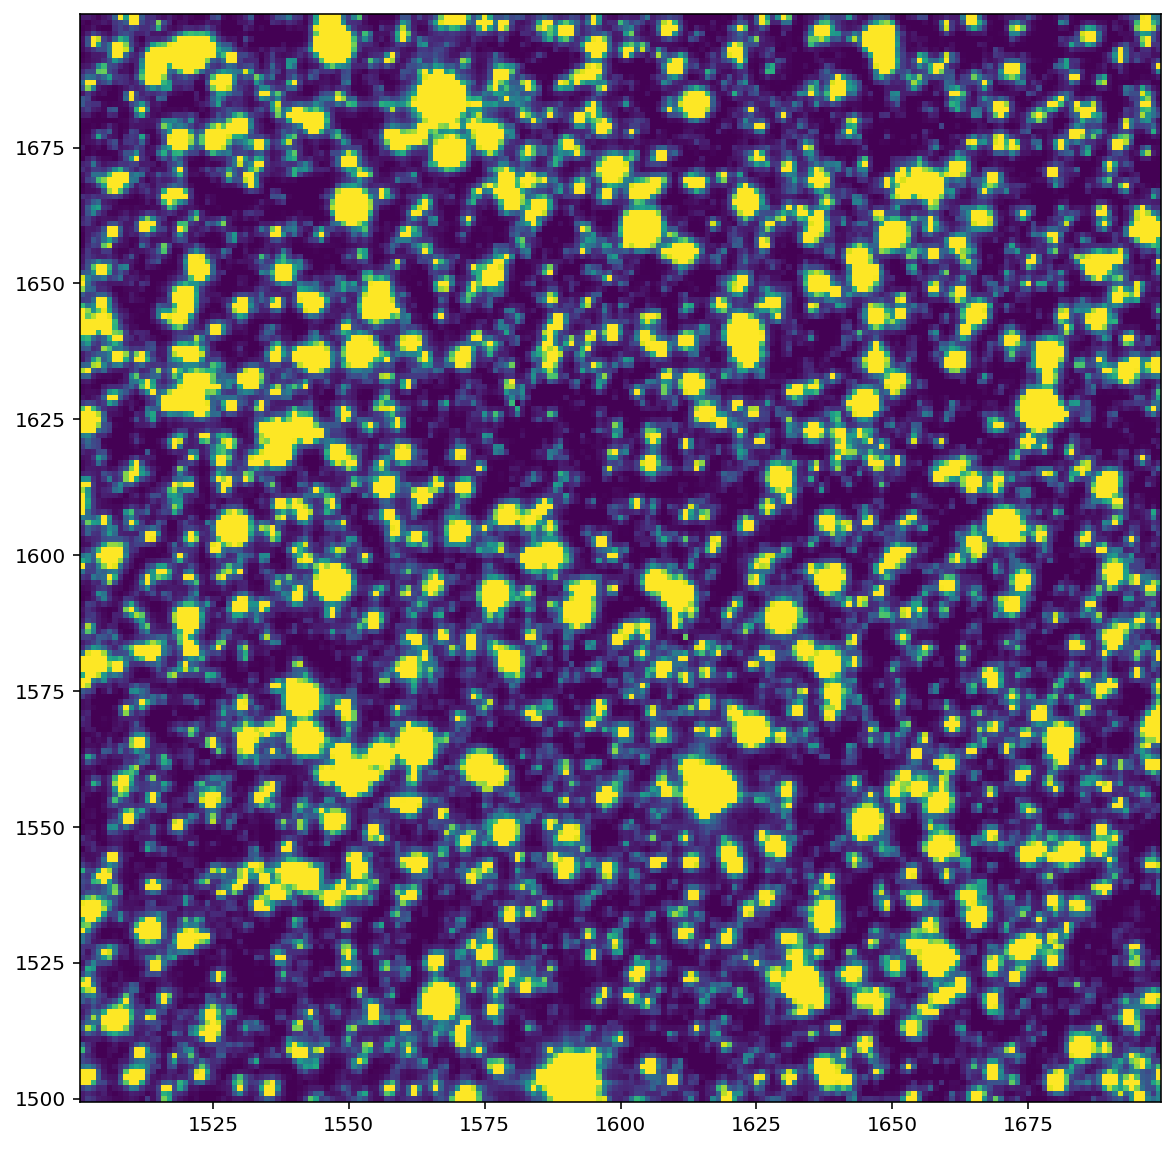

<Figure size 720x720 with 0 Axes>

In [482]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, data, vmin=0, vmax=100)
plt.gca().set_aspect("equal")

plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, s.dot(source_flux).reshape(image_shape), vmin=0, vmax=100)


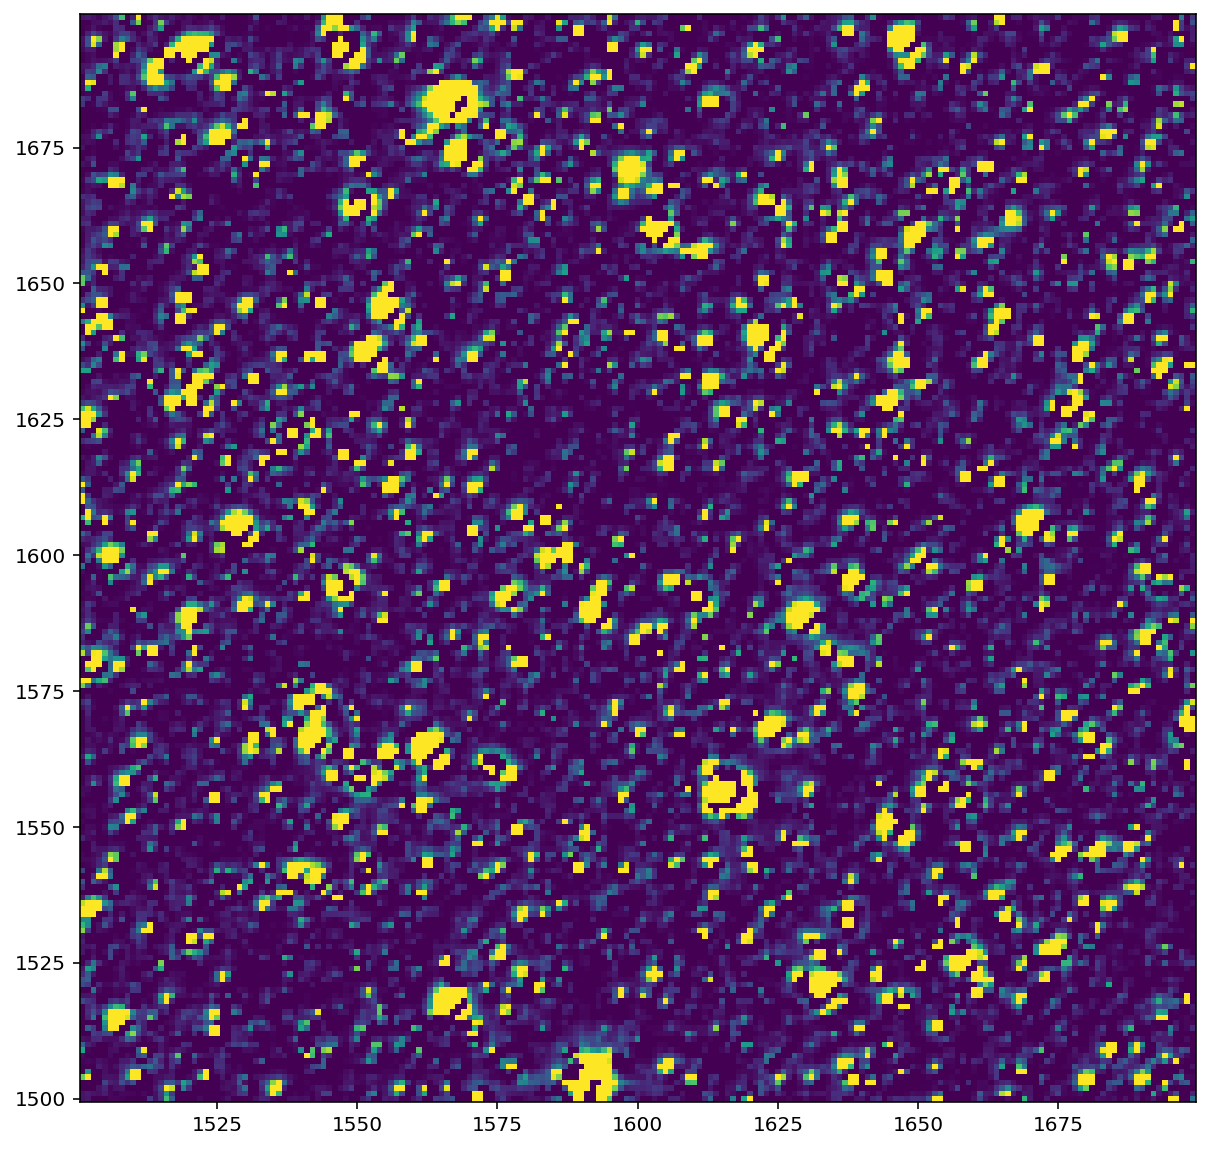

In [392]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, data - s.dot(source_flux).reshape(image_shape), vmin=0, vmax=100)

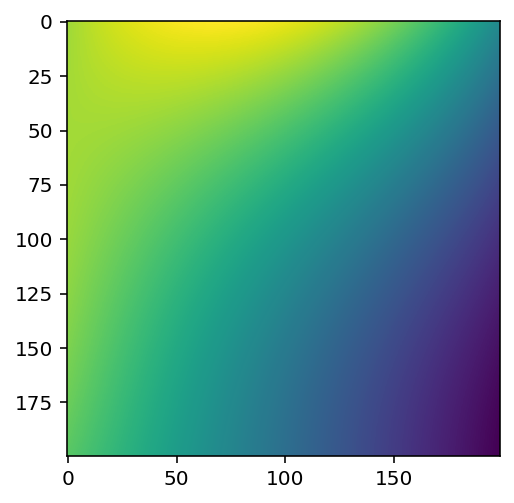

In [334]:
plt.imshow(bkg_model)

/var/folders/bv/0t7fjlgx0mx3_3bdhxqzd7bmh_67k0/T/ipykernel_99040/3613637149.py:2: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data - bkg_model), vmin=1, vmax=2)


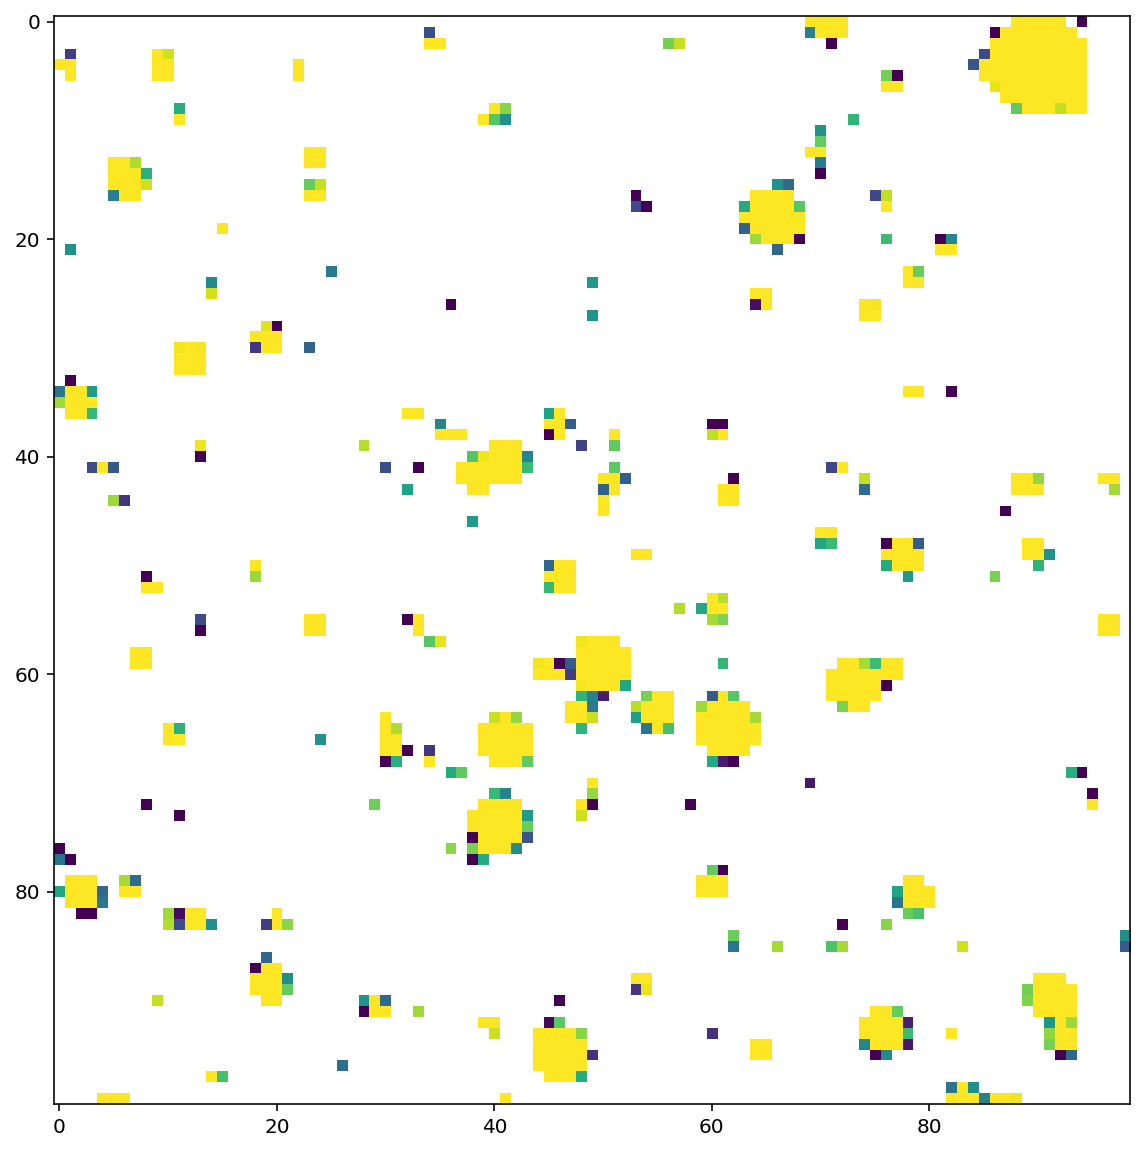

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log10(data - bkg_model), vmin=1, vmax=2)

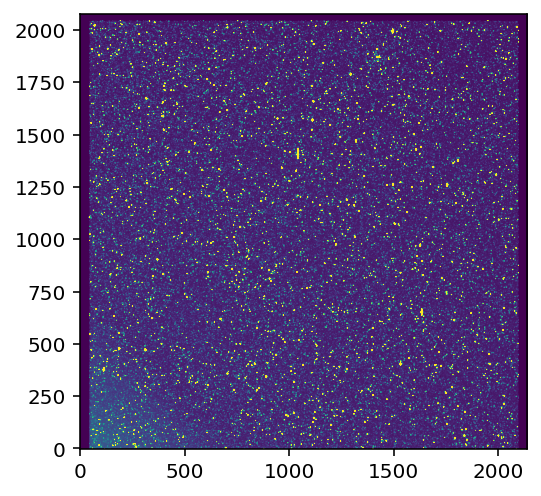

In [181]:
plt.imshow(hdulist[1].data, vmin=100, vmax=1000, origin="lower")